[View in Colaboratory](https://colab.research.google.com/github/sthalles/tensorflow-tutorials/blob/master/MNIST_ConvNet_Solution.ipynb)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras

Using TensorFlow backend.


In [0]:
# Enable eager execution mode
tfe = tf.contrib.eager
tf.enable_eager_execution()

In [3]:
if tf.executing_eagerly():
    print("Eager is Enabled!")

Eager is Enabled!


# Download and Normalize the Training data

![alt text](https://www.tensorflow.org/versions/r1.1/images/MNIST-Matrix.png)

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Load MNIST data

# Visualize the dataset Shape and Stats

In [5]:
print("Train shape:", X_train.shape)
print("Train labels:", y_train.shape)
print("Validation shape:", X_val.shape)
print("Validation labels:", y_val.shape)
print("Test shape:", X_test.shape)
print("Test labels:", y_test.shape)

Train shape: (48000, 28, 28)
Train labels: (48000,)
Validation shape: (12000, 28, 28)
Validation labels: (12000,)
Test shape: (10000, 28, 28)
Test labels: (10000,)


In [0]:
def normalizer(image, label):
  return tf.to_float(image) / 255., label

Train: [4748. 5420. 4784. 4912. 4666. 4317. 4741. 4966. 4691. 4755.]
Test: [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


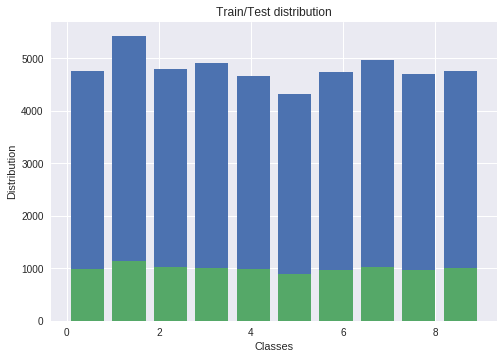

In [7]:
import pylab as P
n, bins, patches = P.hist(y_train, bins=10, histtype="bar", rwidth=0.8)
print("Train:", n)
n, bins, patches = P.hist(y_test, bins=10, histtype="bar", rwidth=0.8 )
print("Test:", n)
P.xlabel('Classes')
P.ylabel('Distribution')
P.title('Train/Test distribution')
P.show()

In [8]:
print("Max value:", np.max(X_train[0]))
print("Min value:", np.min(X_train[0]))
print("Mean:", np.mean(X_train[0]))
print("Std:", np.std(X_train[0]))

Max value: 255
Min value: 0
Mean: 32.81887755102041
Std: 76.27195468984321


## Visualize some MNIST images

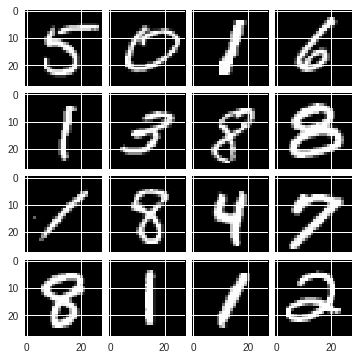

In [9]:
fig = plt.figure(1, (6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(16):
    grid[i].imshow(X_train[i], cmap="gray")  # The AxesGrid object work as a list of axes.

plt.show()

## Building Tensorflow Model

Build your Conv Neural Net. The basic architecture follows a simple sequence of operations.
1- Convolution
2- Activation function
3- Pooling functions

In the end, we usually apply some fully-connected layers to build the classification layer.

Refer to these links for full documentations:

- [Keras Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [Keras MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)


![LeNet-5](https://world4jason.gitbooks.io/research-log/content/deepLearning/CNN/img/lenet.png)

![Convolution](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

In [0]:
class MNISTModel(tf.keras.Model):
    
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1),
                                            padding='same', activation=tf.nn.relu, use_bias=True)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")
        self.flatten = tf.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.logits = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        conv1 = self.conv1(inputs)
        pool1 = self.pool1(conv1)
        flat = self.flatten(pool1)
        fc1 = self.fc1(flat)
        logits = self.logits(fc1)
        return logits

The loss function is responsible for calculating how good/bad our classifier is doing. For multiclass problems, we usually use the cross-entropy function.

![One-hot encodding representation](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRRo9fhLj8UpmziNvD_eifQ3SkjybaaGmlfLd5Z2fsDn3XaASUoWw)

In [0]:
def loss(logits, labels):
    labels_one_hot = tf.one_hot(labels, 10)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_one_hot, logits=logits)
    return tf.reduce_mean(cross_entropy)

# Optimizers

The Optimizer is the algorithm responsible for applying the gradients to the Model's weight variables. Imagine a curved surface (just an example), the goal is to find the minimal value of that surface. The Gradient points to the direction of **steepest ascent**. Thus, we follow the opposite direction of the gradient (**steepest descent**), so we hopefully can find the minimum value of the error surface.

- **AdadeltaOptimizer**: Optimizer that implements the Adadelta algorithm.

- **AdagradOptimizer**: Optimizer that implements the Adagrad algorithm.

- **AdamOptimizer**: Optimizer that implements the Adam algorithm.

- **GradientDescentOptimizer**: Optimizer that implements the gradient descent algorithm.

- **MomentumOptimizer**: Optimizer that implements the Momentum algorithm.

[Tensorflow Build-in Optimizers](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/train)


![alt text](https://cs231n.github.io/assets/nn3/opt1.gif)

In [0]:
# Choose one of the optimizers and set an initial learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [0]:
# Create the model
model = MNISTModel()

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.map(normalizer)
dataset = dataset.shuffle(1000) # shuffle before each epoch and bufferize some data
dataset = dataset.repeat(1) # number of epochs
dataset = dataset.batch(32) # batch size

In [15]:
train_epoch_loss_avg = tfe.metrics.Mean()
train_epoch_accuracy = tfe.metrics.Accuracy()

for (step, (images, labels)) in enumerate(tfe.Iterator(dataset)):
  
  with tfe.GradientTape() as tape:
    logits = model(tf.expand_dims(images, axis=3))
    loss_value = loss(logits, labels)
    
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  
  train_epoch_loss_avg(loss_value)
  train_epoch_accuracy(tf.cast(tf.argmax(logits, axis=1), tf.uint8), labels)
  
  if step % 100 == 0:
    val_logits = model(tf.expand_dims(tf.cast(X_val,tf.float32), axis=3))
    val_predictions = tf.argmax(val_logits, axis=1)
    print("Training loss: {: .3}\tTrain Accuracy: {: .3}\tValidation Accuracy: {: .3}".format(train_epoch_loss_avg.result(), train_epoch_accuracy.result(), accuracy_score(val_predictions, y_val)))

Training loss:  2.31 Train Accuracy:  0.125 Validation Accuracy:  0.168
Training loss:  0.73 Train Accuracy:  0.786 Validation Accuracy:  0.9
Training loss:  0.521 Train Accuracy:  0.848 Validation Accuracy:  0.919
Training loss:  0.425 Train Accuracy:  0.875 Validation Accuracy:  0.931
Training loss:  0.365 Train Accuracy:  0.892 Validation Accuracy:  0.942
Training loss:  0.329 Train Accuracy:  0.902 Validation Accuracy:  0.959
Training loss:  0.3 Train Accuracy:  0.911 Validation Accuracy:  0.949
Training loss:  0.273 Train Accuracy:  0.919 Validation Accuracy:  0.96
Training loss:  0.254 Train Accuracy:  0.925 Validation Accuracy:  0.951
Training loss:  0.239 Train Accuracy:  0.93 Validation Accuracy:  0.962
Training loss:  0.227 Train Accuracy:  0.933 Validation Accuracy:  0.945
Training loss:  0.215 Train Accuracy:  0.936 Validation Accuracy:  0.966
Training loss:  0.205 Train Accuracy:  0.939 Validation Accuracy:  0.953
Training loss:  0.197 Train Accuracy:  0.942 Validation Acc

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def normalized_acc(conf_matrix):
    for i in range(conf_matrix.shape[0]):
        print("Acc class {0} --> {1: .3}".format(i, conf_matrix[i,i]/sum(conf_matrix[i])))

In [38]:
test_logits = model(tf.expand_dims(tf.cast(X_test,tf.float32), axis=3))
test_predictions = tf.argmax(test_logits, axis=1)
print("Test Overall Accuracy: {: .3}".format(accuracy_score(test_predictions, y_test)))

Test Accuracy:  0.946


Confusion matrix, without normalization


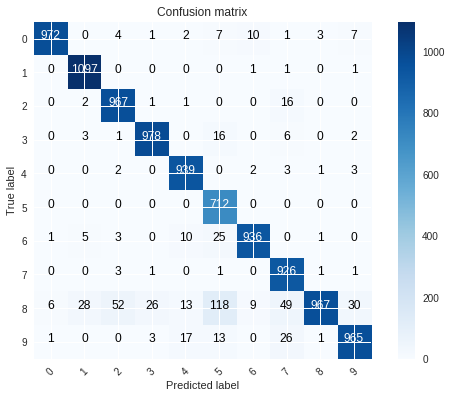

In [39]:
conf_matrix = confusion_matrix(test_predictions, y_test)
_ = plot_confusion_matrix(conf_matrix, classes=[str(i) for i in range(10)])

In [40]:
normalized_acc(conf_matrix)

Acc class 0 -->  0.965
Acc class 1 -->  0.997
Acc class 2 -->  0.98
Acc class 3 -->  0.972
Acc class 4 -->  0.988
Acc class 5 -->  1.0
Acc class 6 -->  0.954
Acc class 7 -->  0.992
Acc class 8 -->  0.745
Acc class 9 -->  0.941
